# Welcome to NetBeez API examples - Retrive PING test results from a specific agent

This notebook uses a Python environment to demonstrate how a NetBeez user can retrive data from the API.

In this example we will be searching for an agent by name, then selecting the ping tests that are currently running, and then retriving the raw measurement results for those tests from the past 60 minutes.

## Setup your NetBeez Beezkeeper details

First you need to identify your server's FQDN and generate an API key to use in these examples.

If the URL you use to access NetBeez looks like this https://demo.netbeecloud.net then `demo.netbeecloud.net` is the fqdn.

In [1]:
beezkeeper_fqdn="demo.netbeezcloud.net"
base_url='https://' + beezkeeper_fqdn

In [2]:
from IPython.display import Markdown as md

md(f"To generate an API key head over to https://{beezkeeper_fqdn}/#settings-tab/api-keys-settings")

To generate an API key head over to https://demo.netbeezcloud.net/#settings-tab/api-keys-settings

In [3]:
api_key="7g5_hKXw_460SNKEkJEYlMn1eqw3iTmaus_cCMZ8REhc5MOEtEAx8g"

## Setup the headers
We define the content type format as JSON and provide the API key that you generated in the previous step as part of the headers.

In [4]:
import requests
import urllib3

urllib3.disable_warnings()


headers = {
            'Cache-Control': 'no-store',
            'Content-type': 'application/json',
            'Authorization': 'Bearer ' + api_key
          }

legacy_api_headers = {
    'Authorization': api_key,
    'API-VERSION': 'v1',
    'Content-type': 'application/json'
}

Note that when the legacy api headers are used it means that we are using the legacy API which is subject to be replaced soon by the new JSON API (documentation here: https://api.netbeez.net)

# Get NetBeez Agent information and last 24 hours Ping results

## Retrieve the agent
First we set retrieve the agent by search by name using this API endpoint: https://api.netbeez.net/#f3d48709-5344-45b7-af9b-7b92feddd4ec.

In [5]:
search_name = "Rome"
url = f"{base_url}/agents?filter[name]={search_name}&type=beta"


In [6]:
response = requests.request("GET", url, headers=headers, verify=False)

import json
data = json.loads(response.text)
agent = data['data'][0]
print(agent)

{'id': '343', 'type': 'agent', 'attributes': {'name': 'Rome', 'reached_target_test_limit': False, 'reached_scheduled_test_limit': None, 'nb_target_ids': [437, 32], 'nb_test_ids': [1698492, 1698493, 1698494, 1698489, 1698490, 1698491, 1698495, 1698496], 'agent_type_name': 'rpi-model-b-3', 'os_version': 'Raspbian GNU/Linux 9.11 (stretch)', 'kernel_version': '#1253 SMP Thu Aug 15 11:49:46 BST 2019', 'uuid': '1d2dbb0a-f034-499a-b1fd-9f27d8f0ca6c', 'agent_class': 'faste', 'active': True, 'active_ts': 1623773876580, 'description': None, 'category': 'network_agent', 'software_version': '8.0.6', 'open_incident_id': None, 'test_aggregate_counts_by_type': {'1': {'success': 2, 'fail': 0, 'warning': 0, 'paused': 0, 'unknown': 0}, '2': {'success': 2, 'fail': 0, 'warning': 0, 'paused': 0, 'unknown': 0}, '3': {'success': 2, 'fail': 0, 'warning': 0, 'paused': 0, 'unknown': 0}, '4': {'success': 1, 'fail': 0, 'warning': 0, 'paused': 0, 'unknown': 0}}}, 'relationships': {'network_interfaces': {'data': [{

## Retrieve Ping tests
Then we iterate through the tests and select the ping tests.

In [7]:
nb_tests = []
for nb_test_id in agent['attributes']['nb_test_ids']:
  url = f"{base_url}/nb_tests/{nb_test_id}.json"
  response = requests.request("GET", url, headers=legacy_api_headers, verify=False)
  data = json.loads(response.text)
  if data['heir_type'] == 'PingTest':
    print(data)
    nb_tests.append(data)


{'id': 1698492, 'target': 'www.google.com', 'count': 0, 'interval': 5, 'timeout': 5, 'start_ts': '2021-06-15T11:39:06.773-04:00', 'created_at': '2021-06-15T15:39:06.000Z', 'updated_at': '2021-06-24T14:04:21.000Z', 'agent_id': 343, 'test_type_id': 1, 'heir_id': 11483, 'heir_type': 'PingTest', 'ad_hoc': False, 'test_name': None, 'nb_test_templatable_type': 'NbTestTemplate', 'nb_test_templatable_id': 99, 'current_alert_mode': 'success', 'wifi_profile_id': None, 'network_interface_id': 389, 'nb_target_id': 32, 'nb_test_template_id': 99, 'schedule_type': 'periodic', 'options': {'data_size': 54, 'dont_fragment': False, 'tos': None, 'port': None, 'ping_type': 2, 'flags': None, 'jitter_mos': True}, 'alert_mode': 'success', 'interface_type': 'wired'}
{'id': 1698489, 'target': 'demo-app.netbeezcloud.net', 'count': 0, 'interval': 5, 'timeout': 5, 'start_ts': '2021-06-15T11:39:06.605-04:00', 'created_at': '2021-06-15T15:39:06.000Z', 'updated_at': '2021-06-23T17:18:55.000Z', 'agent_id': 343, 'test_

## Retrive the results
Then we retrieve the results for the past 60 minutes.

In [8]:
import time
import datetime
to_ts = int(time.time() * 1000)
from_ts = to_ts - (60 * 60 * 1000)

print(datetime.datetime.fromtimestamp(from_ts/1000.0))
print(datetime.datetime.fromtimestamp(to_ts/1000.0))


2021-06-24 17:48:52.474000
2021-06-24 18:48:52.474000


In [9]:
results = []
import pandas as pd
for nb_test in nb_tests:
  url = f"{base_url}/results.json?nb_test_id={nb_test['id']}&from={from_ts}&to={to_ts}"
  response = requests.request("GET", url, headers=legacy_api_headers, verify=False)
  df = pd.json_normalize(json.loads(response.text), 'index')
  df['timestamp'] = df['timestamp'].transform(lambda x: datetime.datetime.fromtimestamp(x/1000.0))
  df.set_index('id', inplace=True)
  results.append(df)
    
results = pd.concat(results)

...and here is a printout of the results:

In [10]:
print(results)

            value               timestamp  sequence_number  nb_test_id
id                                                                    
9870759582   47.9 2021-06-24 17:48:56.341            17617     1698492
9870759841   45.9 2021-06-24 17:49:01.342            17618     1698492
9870760070   46.5 2021-06-24 17:49:06.342            17619     1698492
9870760093   45.8 2021-06-24 17:49:11.352            17620     1698492
9870760312   46.2 2021-06-24 17:49:16.359            17621     1698492
...           ...                     ...              ...         ...
9870890803  110.0 2021-06-24 18:48:26.226            18330     1698489
9870890920  109.0 2021-06-24 18:48:31.234            18331     1698489
9870891156  109.0 2021-06-24 18:48:36.235            18332     1698489
9870891400  108.0 2021-06-24 18:48:41.236            18333     1698489
9870891533  109.0 2021-06-24 18:48:46.241            18334     1698489

[1436 rows x 4 columns]


In [14]:
results_pivot = results.pivot(index='timestamp', columns='nb_test_id', values='value')
pf = results_pivot.interpolate()

<AxesSubplot:xlabel='timestamp'>

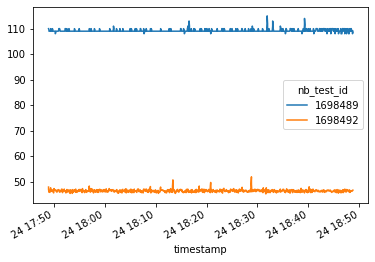

In [12]:
pf.plot()